In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
df_new = pd.read_pickle(r'C:\Users\nishi\Desktop\EECS 731 - Data Science\Project\df_new.pkl')

In [3]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

df_new = df_new.sample(frac=1).reset_index(drop=True)


1.12.0


In [4]:
X = df_new[['trip_distance','trip_duration']]
y = df_new[['fare_amount']]

In [5]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.10, random_state = 42)

In [6]:
# Shuffle the training set
# order = np.argsort(np.random.random(train_labels.shape))
# train_data = np.array(train_data)
#train_labels = np.array(train_labels)
#train_data = train_data[order]
#train_labels = train_labels[order]

In [7]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (2024739, 2)
Testing set:  (224972, 2)


In [8]:
# Normalizing Features

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [9]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Wall time: 100 ms


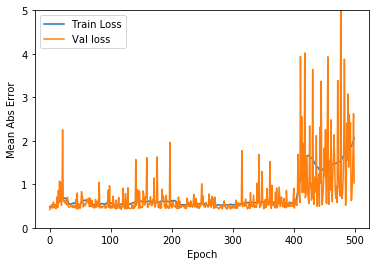

In [11]:
%%time
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)


................................................Wall time: 32min 3s


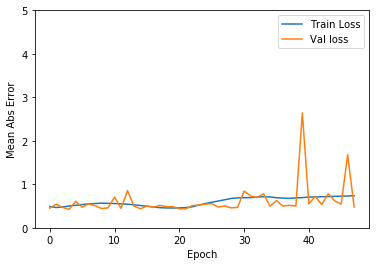

In [12]:
%%time
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [13]:
%%time
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae))

Testing set Mean Abs Error: $   0.48
Wall time: 2.67 s


Wall time: 2.67 s


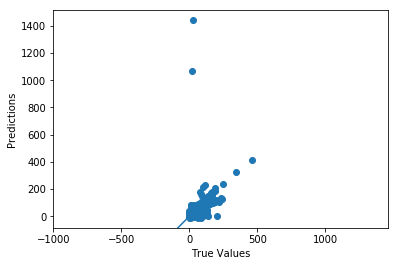

In [14]:
%%time
test_predictions = model.predict(test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [15]:
result = test_data
result['predicted_fare'] = test_predictions
result['actual_fare'] = test_labels
result['difference'] = abs(result['predicted_fare']-result['actual_fare'])

In [16]:
result.head()

,trip_distance,trip_duration,predicted_fare,actual_fare,difference
1937401,1.040160,0.307876,17.668728,18.5,0.831272
868829,0.496414,1.275410,18.670464,18.0,0.670464
1992601,-0.736076,-0.927884,4.018048,4.5,0.481952
1952741,0.713913,0.319052,16.380497,16.0,0.380497
1832239,0.206417,0.263172,13.503861,13.0,0.503861


In [19]:
print("Model Accuracy % : " +str((result[result['difference'] < 1].shape[0]/result.shape[0]) * 100)[:5])

Model Accuracy % : 93.63


Wall time: 37.7 ms


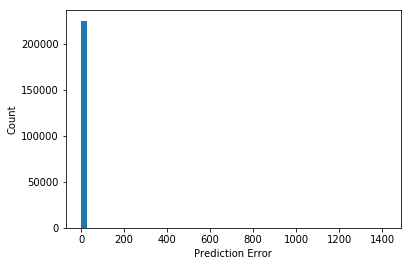

In [18]:
%%time
plt.hist(result['difference'], bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")